# Run Presto on Darfur Dataset

**Author**: Ivan Zvonkov

**Last Modified**: Feb 19, 2024

**Description**: Runs Presto on Darfur dataset.

In [1]:
import sys
import pandas as pd

from tqdm.notebook import tqdm

sys.path.append("../..")

from datasets import datasets

## 1. Load in data

In [2]:
# Takes a minute and a half
dfs = []
for d in tqdm(datasets):
    df = d.load_df(to_np=True, disable_tqdm=True)
    df["name"] = d.name
    dfs.append(df)
df = pd.concat(dfs)
df["is_crop"] = df["class_probability"] > 0.5

  0%|          | 0/47 [00:00<?, ?it/s]

/var/folders/1v/87y9n_d5143c_6cp072v3b1c0000gn/T/ipykernel_57996/4119029012.py:4: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  df = d.load_df(to_np=True, disable_tqdm=True)


In [150]:
len(df)

114573

In [151]:
# Filter out 0.5
df = df[df["class_probability"] != 0.5].copy()

In [152]:
len(df)

112719

## 2. Setup training and evaluation sets

In [153]:
from src.bboxes import bboxes

In [154]:
df[df["name"] == "SudanGedarefDarfurAlJazirah2022"]["subset"].value_counts()

training      405
testing       335
validation    296
Name: subset, dtype: int64

In [155]:
# Fewer points because many failed on GEE
df[df["name"] == "SudanGedarefDarfurAlJazirah2023"]["subset"].value_counts()

training      277
testing       239
validation    215
Name: subset, dtype: int64

In [156]:
is_test_2022 = (df["name"] == "SudanGedarefDarfurAlJazirah2022") & (df["subset"] != "training")
is_test_2023 = (df["name"] == "SudanGedarefDarfurAlJazirah2023") & (df["subset"] != "training")

In [157]:
bbox_name = "Sudan_South"

is_local_lat = (df.lat >= bboxes[bbox_name].min_lat) & (df.lat <= bboxes[bbox_name].max_lat)
is_local_lon = (df.lon >= bboxes[bbox_name].min_lon) & (df.lon <= bboxes[bbox_name].max_lon)

In [158]:
df["months"] = df["eo_data"].apply(lambda x: x.shape[0])

In [159]:
df[df["name"] == "SudanGedarefDarfurAlJazirah2022"]["months"].value_counts()

19    1036
Name: months, dtype: int64

In [160]:
df[df["name"] == "SudanGedarefDarfurAlJazirah2023"]["months"].value_counts()

10    731
Name: months, dtype: int64

In [161]:
# Have to exclude both test sets from either training sets with Presto
# because Presto uses lat lons as input, so bias would be introduced
df_train_2022 = df[is_local_lat & is_local_lon & ~is_test_2022 & ~is_test_2022 & (df["months"] > 18)]
df_train_2023 = df[is_local_lat & is_local_lon & ~is_test_2023 & ~is_test_2023]
df_test_2022 = df[is_test_2022].copy() # Will add predictions to this
df_test_2023 = df[is_test_2023].copy() # Will add predictions to this

In [162]:
len(df_train_2022), len(df_test_2022)

(7410, 631)

In [163]:
len(df_train_2023), len(df_test_2023)

(8318, 454)

## 3. Convert to Presto Tensor Datasets 

In [164]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from openmapflow.bands import BANDS
from src.single_file_presto_v2 import Presto, DEVICE, Aggregate

In [165]:
ADD_BY = np.zeros(18)
ADD_BY[0:2] = [25.0, 25.0]     # Sentinel-1 VV, VH (range from -50 to 1)
ADD_BY[13] = -272.15           # ERA5 Celcius

DIVIDE_BY = np.ones(18)
DIVIDE_BY[0:2] = [25.0, 25.0]   # Sentinel-1 VV, VH (range from -50 to 1)
DIVIDE_BY[2:13] = [10000.0] * 11 # Sentinel-2 high band values
DIVIDE_BY[13] = 35.0            # ERA5 high celcius value
DIVIDE_BY[14] = 0.03            # ERA5 high precipitation value
DIVIDE_BY[15] = 2000.0          # SRTM elevation high value
DIVIDE_BY[16] = 50.0            # Slope high value

def normalize(x):
    keep_indices = [idx for idx, val in enumerate(BANDS) if val != "B9"] # remove the b9 band
    normalized = ((x + ADD_BY) / DIVIDE_BY).astype(np.float32)
    return normalized[:, keep_indices]

In [166]:
class PrestoDataset(Dataset):
    def __init__(self, arg_df, start_month=1, months=12):
        xs_list = [normalize(x[start_month:start_month+months]) for x in arg_df["eo_data"].to_list()]
        self.xs_tensors = [torch.from_numpy(x).to(DEVICE).float() for x in xs_list]

        self.latlons = [np.stack([lat, lon], axis=-1) for lat, lon in zip(arg_df["eo_lat"].to_list(), arg_df["eo_lon"].to_list())]
        self.latlons_tensors = [torch.from_numpy(latlon).to(DEVICE).float() for latlon in self.latlons]
        
        self.is_crop_tensors = [torch.tensor(is_crop, dtype=torch.float32) for is_crop in arg_df["is_crop"].astype(int).to_list()]
        self.start_month = start_month
        self.dw_mask = (torch.ones(months) * 9).long()
        
    def __len__(self):
        return len(self.xs_tensors)
    
    def __getitem__(self, idx):
        x = self.xs_tensors[idx]
        latlons = self.latlons_tensors[idx]
        is_crop = self.is_crop_tensors[idx]
        return x, latlons, self.dw_mask, self.start_month, is_crop

In [167]:
train_dataset_2022 = PrestoDataset(df_train_2022, start_month=1)
test_dataset_2022 = PrestoDataset(df_test_2022, start_month=1) 
train_dataset_2023 = PrestoDataset(df_train_2023, start_month=0, months=10)
test_dataset_2023 = PrestoDataset(df_test_2023, start_month=0, months=10)

## 4. Generate encodings using Presto

In [171]:
encoder_decoder = Presto.load_pretrained("../../data/presto/default_model_v2.pt")
pretrained_model = encoder_decoder.encoder.eval()

In [172]:
def generate_encodings(dataset, aggregate=Aggregate.MEAN):
    dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=False)
    feature_list = []
    for (x, latlons, dw, start_month, _) in tqdm(dataloader, desc="Encodings", leave=False):
        with torch.no_grad():
            encodings = (pretrained_model(
                x, dynamic_world=dw, latlons=latlons, month=start_month, aggregate=aggregate
            )).cpu().numpy()
            feature_list.append(encodings)
    return np.concatenate(feature_list)

In [173]:
X_train_2022 = generate_encodings(train_dataset_2022)
X_test_2022 = generate_encodings(test_dataset_2022)
y_train_2022 = df_train_2022["is_crop"].to_list() 
y_test_2022 = df_test_2022["is_crop"].to_list()

Encodings:   0%|          | 0/116 [00:00<?, ?it/s]

Encodings:   0%|          | 0/10 [00:00<?, ?it/s]

In [174]:
X_train_2023 = generate_encodings(train_dataset_2023)
X_test_2023 = generate_encodings(test_dataset_2023)
y_train_2023 = df_train_2023["is_crop"].to_list() 
y_test_2023 = df_test_2023["is_crop"].to_list()

Encodings:   0%|          | 0/130 [00:00<?, ?it/s]

Encodings:   0%|          | 0/8 [00:00<?, ?it/s]

## 5. Train Logistic Regression on Encodings

In [175]:
from sklearn.linear_model import LogisticRegression

In [176]:
DEFAULT_SEED = 42

In [177]:
model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=DEFAULT_SEED)
model.fit(X_train_2022, y_train_2022)
y_pred_proba = model.predict_proba(X_test_2022)[:, 1]
df_test_2022["preds"] = (y_pred_proba > 0.5).astype(int)

In [178]:
model = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=DEFAULT_SEED)
model.fit(X_train_2023, y_train_2023)
y_pred_proba = model.predict_proba(X_test_2023)[:, 1]
df_test_2023["preds"] = (y_pred_proba > 0.5).astype(int)

## 6. Isolate Darfur Predictions

In [179]:
# Isolate Darfur points
import ee
import geemap

In [180]:
ee.Initialize()

In [181]:
# Load ROIs from Google Earth Engine
roi_fc = ee.FeatureCollection("projects/ee-gmuhawenayo/assets/rois")
Central_Darfur_roi = roi_fc.filter("NAME_1 == 'Central Darfur'")
West_Darfur_roi = roi_fc.filter("NAME_1 == 'West Darfur'")
South_Darfur_roi = roi_fc.filter("NAME_1 == 'South Darfur'")

In [182]:
# Convert reference sample sets to feature collections
def ee_feature_from_row(row):
    return ee.Feature(ee.Geometry.Point(row.lon, row.lat), {"is_crop": row.is_crop, "preds": row.preds})

ee_fc_2022 = ee.FeatureCollection(df_test_2022.apply(ee_feature_from_row, axis=1).to_list())
ee_fc_2023 = ee.FeatureCollection(df_test_2023.apply(ee_feature_from_row, axis=1).to_list())

In [183]:
df_2022_Central_Darfur = geemap.ee_to_gdf(ee_fc_2022.filterBounds(Central_Darfur_roi))
df_2022_West_Darfur = geemap.ee_to_gdf(ee_fc_2022.filterBounds(West_Darfur_roi))
df_2022_South_Darfur = geemap.ee_to_gdf(ee_fc_2022.filterBounds(South_Darfur_roi))

df_2023_Central_Darfur = geemap.ee_to_gdf(ee_fc_2023.filterBounds(Central_Darfur_roi))
df_2023_West_Darfur = geemap.ee_to_gdf(ee_fc_2023.filterBounds(West_Darfur_roi))
df_2023_South_Darfur = geemap.ee_to_gdf(ee_fc_2023.filterBounds(South_Darfur_roi))

In [184]:
len(df_2022_Central_Darfur)

103

In [185]:
len(df_2022_West_Darfur)

61

In [186]:
len(df_2022_South_Darfur)

163

## 7. Darfur Metrics

In [187]:
from sklearn.metrics import (
    f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

In [188]:
def metrics(region_name, region_df):
    y_test, y_pred = region_df["is_crop"], region_df["preds"]
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-crop", "Crop"])
    fig, ax = plt.subplots(figsize=(2, 2))
    disp.plot(ax=ax)
    print("-"* 50)
    print(f"REGION: {region_name}")
    print("-"* 50)
    print(f"Users: {precision_score(y_test, y_pred):.3} \tOverall: {accuracy_score(y_test, y_pred):.3}")
    print(f"Producers: {recall_score(y_test, y_pred):.3} \tF1: {f1_score(y_test, y_pred):.3}")

### Darfur 2022

--------------------------------------------------
REGION: Darfur 2022
--------------------------------------------------
Users: 0.311 	Overall: 0.844
Producers: 0.412 	F1: 0.354


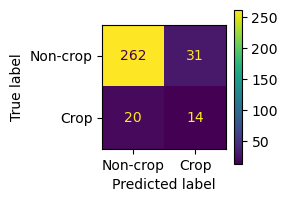

In [189]:
metrics("Darfur 2022", pd.concat([df_2022_Central_Darfur, df_2022_West_Darfur, df_2022_South_Darfur]))

--------------------------------------------------
REGION: Central Darfur 2022
--------------------------------------------------
Users: 0.188 	Overall: 0.748
Producers: 0.188 	F1: 0.188


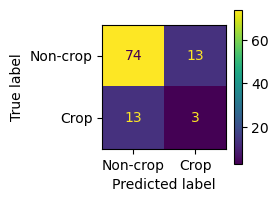

In [190]:
metrics("Central Darfur 2022", df_2022_Central_Darfur)

--------------------------------------------------
REGION: West Darfur 2022
--------------------------------------------------
Users: 0.375 	Overall: 0.918
Producers: 1.0 	F1: 0.545


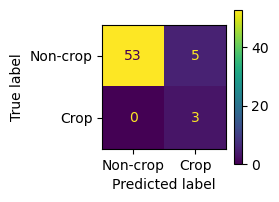

In [191]:
metrics("West Darfur 2022", df_2022_West_Darfur)

--------------------------------------------------
REGION: South Darfur 2022
--------------------------------------------------
Users: 0.381 	Overall: 0.877
Producers: 0.533 	F1: 0.444


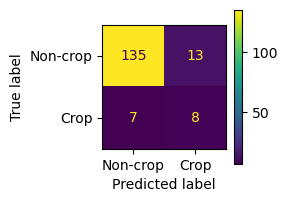

In [192]:
metrics("South Darfur 2022", df_2022_South_Darfur)

### Darfur 2023

--------------------------------------------------
REGION: Darfur 2023
--------------------------------------------------
Users: 0.353 	Overall: 0.909
Producers: 0.261 	F1: 0.3


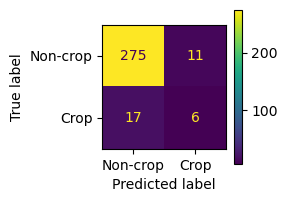

In [193]:
metrics("Darfur 2023", pd.concat([df_2023_Central_Darfur, df_2023_West_Darfur, df_2023_South_Darfur]))

--------------------------------------------------
REGION: Central Darfur 2023
--------------------------------------------------
Users: 0.0 	Overall: 0.854
Producers: 0.0 	F1: 0.0


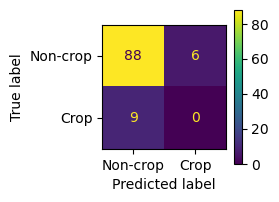

In [194]:
metrics("Central Darfur 2023", df_2023_Central_Darfur)

--------------------------------------------------
REGION: West Darfur 2023
--------------------------------------------------
Users: 1.0 	Overall: 0.966
Producers: 0.333 	F1: 0.5


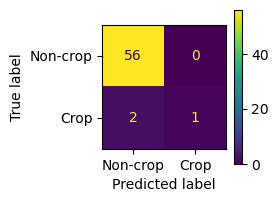

In [195]:
metrics("West Darfur 2023", df_2023_West_Darfur)

--------------------------------------------------
REGION: South Darfur 2023
--------------------------------------------------
Users: 0.5 	Overall: 0.925
Producers: 0.455 	F1: 0.476


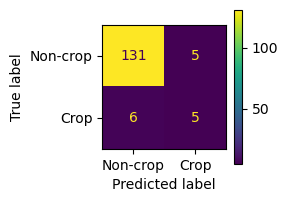

In [196]:
metrics("South Darfur 2023", df_2023_South_Darfur)